# **this code with help from :**

https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=4wxY3x-ZZz8h

In [ ]:
!C:\Users\Hammad\Documents\Python_Envs\bert_trans_env\Scripts\activate.bat
!pip install ipykernel
!python -m ipykernel install --user --name=bert_trans

In [1]:
!pip install transformers

     ---------------------------------------- 6.3/6.3 MB 2.8 MB/s eta 0:00:00
     -------------------------------------- 78.5/78.5 kB 874.7 kB/s eta 0:00:00
     ------------------------------------ 267.7/267.7 kB 916.2 kB/s eta 0:00:00
     -------------------------------------- 190.3/190.3 kB 1.2 MB/s eta 0:00:00
     ------------------------------------ 151.7/151.7 kB 822.2 kB/s eta 0:00:00
     ---------------------------------------- 3.3/3.3 MB 1.3 MB/s eta 0:00:00
     -------------------------------------- 62.8/62.8 kB 848.1 kB/s eta 0:00:00
     ---------------------------------------- 14.8/14.8 MB 1.5 MB/s eta 0:00:00
     -------------------------------------- 155.3/155.3 kB 1.3 MB/s eta 0:00:00
     -------------------------------------- 140.6/140.6 kB 1.7 MB/s eta 0:00:00
     ---------------------------------------- 96.5/96.5 kB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 61.5/61.5 kB 1.7 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
     -------------------------------------- 164.2/164.2 MB 1.7 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 921.5 kB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 3.9 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
!pip install scikit-learn nltk tensorflow pandas matplotlib

     ---------------------------------------- 7.6/7.6 MB 2.3 MB/s eta 0:00:00
     -------------------------------------- 163.0/163.0 kB 1.1 MB/s eta 0:00:00
     -------------------------------------- 965.4/965.4 kB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 98.3/98.3 kB 1.1 MB/s eta 0:00:00
     -------------------------------------- 55.3/55.3 kB 957.9 kB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf

from transformers import BertForSequenceClassification, BertTokenizer, RobertaForSequenceClassification, RobertaTokenizer, AdamW, RobertaModel


from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, precision_score, recall_score

from tqdm.notebook import trange, tqdm
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import json
from uuid import uuid4

import matplotlib.pyplot as plt

In [9]:
df=pd.read_csv("Africa_1997-2020_Jan08.csv",sep=';')

In [10]:
df

,ISO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,...,ADMIN3,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,SOURCE,SOURCE_SCALE,NOTES,FATALITIES,TIMESTAMP
0,12,ALG1,1,01-janvier-1997,1997,1,Violence against civilians,Attack,GIA: Armed Islamic Group,NaN,...,NaN,Douaouda,36672,2789,1,Algeria Watch,Other,5 January: Beheading of 5 citizens in Douaouda...,5,1582579226
1,12,ALG2,2,02-janvier-1997,1997,1,Violence against civilians,Attack,GIA: Armed Islamic Group,NaN,...,NaN,Hassasna,36133,883,1,Algeria Watch,Other,Two citizens were beheaded in Hassasna.,2,1582579226
2,12,ALG3,3,03-janvier-1997,1997,1,Violence against civilians,Attack,GIA: Armed Islamic Group,NaN,...,NaN,Hassi El Abed,34966,"-0,29",1,Algeria Watch,Other,Two citizens were killed in a raid on the vill...,2,1582579226
3,12,ALG4,4,04-janvier-1997,1997,1,Violence against civilians,Attack,GIA: Armed Islamic Group,NaN,...,NaN,Blida,36469,2829,1,Algeria Watch,Other,4 January: 16 citizens were murdered in the vi...,16,1582579226
4,12,ALG5,5,05-janvier-1997,1997,1,Violence against civilians,Attack,GIA: Armed Islamic Group,NaN,...,NaN,Douaouda,36672,2789,1,Algeria Watch,Other,5 January: Killing of 18 citizens in the Olivi...,18,1582579226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65530,404,KEN318,318,25-octobre-1998,1998,1,Violence against civilians,Attack,OLF: Oromo Liberation Front,Borana Ethnic Militia (Kenya),...,Township,Tuli,1643,40343,1,All Africa,Regional,OLF and Borana ethnic militia attack civilians...,28,1553544833
65531,404,KEN319,319,02-novembre-1998,1998,1,Protests,Peaceful protest,Protesters (Kenya),Students (Kenya),...,Nairobi Central,Nairobi,-1283,36817,1,All Africa,Regional,University students protest over killing in Wa...,0,1567465412
65532,404,KEN320,320,10-novembre-1998,1998,1,Battles,Armed clash,SPLM/A: Sudan People's Liberation Movement/Army,NaN,...,Nairobi Central,Nairobi,-1283,36817,1,All Africa,Regional,Garangs SPLA security men raid home of Kerubin...,0,1604344065
65533,404,KEN323,323,14-novembre-1998,1998,1,Battles,Armed clash,SPLM/A: Sudan People's Liberation Movement/Army,NaN,...,Nairobi Central,Nairobi,-1283,36817,1,All Africa,Regional,Rival SPLA factions battle at police station,0,1583194169


In [11]:
# chose the columns  ( Notes and Event type)
df=df[['NOTES','EVENT_TYPE']]

In [12]:
df

,NOTES,EVENT_TYPE
0,5 January: Beheading of 5 citizens in Douaouda...,Violence against civilians
1,Two citizens were beheaded in Hassasna.,Violence against civilians
2,Two citizens were killed in a raid on the vill...,Violence against civilians
3,4 January: 16 citizens were murdered in the vi...,Violence against civilians
4,5 January: Killing of 18 citizens in the Olivi...,Violence against civilians
...,...,...
65530,OLF and Borana ethnic militia attack civilians...,Violence against civilians
65531,University students protest over killing in Wa...,Protests
65532,Garangs SPLA security men raid home of Kerubin...,Battles
65533,Rival SPLA factions battle at police station,Battles


In [13]:
df['EVENT_TYPE'].value_counts()

Battles                       20148
Violence against civilians    18449
Protests                      13719
Riots                          5768
Strategic developments         5258
Explosions/Remote violence     2193
Name: EVENT_TYPE, dtype: int64

<Axes: xlabel='EVENT_TYPE'>

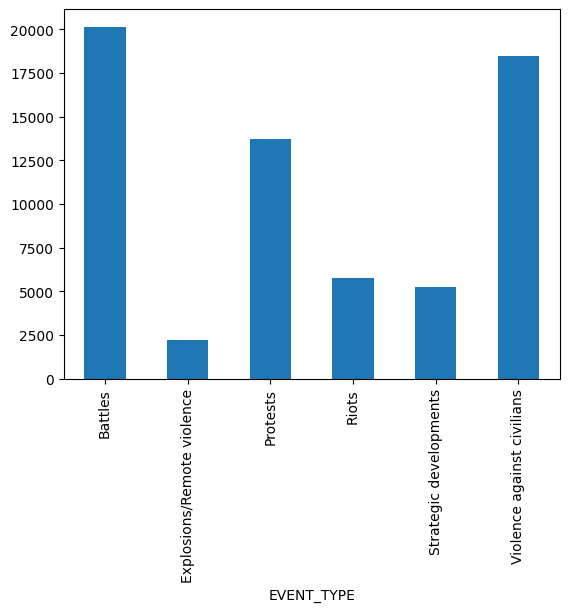

In [17]:
df.groupby(['EVENT_TYPE']).size().plot.bar()

# **Data Preprocessing**

In [18]:
#Text Preprocessing:


# Lowercase text
df["NOTES"] = df["NOTES"].str.lower()

# Remove punctuation
df["NOTES"] = df["NOTES"].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)) if isinstance(x, str) else '')


# Remove stop words
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
df["NOTES"] = df["NOTES"].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))

# Remove numbers
df["NOTES"] = df["NOTES"].apply(lambda x: re.sub(r'\d', '', str(x)))

C:\Users\Hammad\AppData\Local\Temp\ipykernel_13720\2053346679.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["NOTES"] = df["NOTES"].str.lower()
C:\Users\Hammad\AppData\Local\Temp\ipykernel_13720\2053346679.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["NOTES"] = df["NOTES"].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)) if isinstance(x, str) else '')
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hammad\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stop

In [19]:
df

,NOTES,EVENT_TYPE
0,january beheading citizens douaouda tipaza,Violence against civilians
1,two citizens beheaded hassasna,Violence against civilians
2,two citizens killed raid village hassi el abd ...,Violence against civilians
3,january citizens murdered village benachour ...,Violence against civilians
4,january killing citizens oliviers district d...,Violence against civilians
...,...,...
65530,olf borana ethnic militia attack civilians mas...,Violence against civilians
65531,university students protest killing wajir dist...,Protests
65532,garangs spla security men raid home kerubino s...,Battles
65533,rival spla factions battle police station,Battles


In [20]:
df.isnull().sum()

NOTES         0
EVENT_TYPE    0
dtype: int64

In [23]:
# df.dropna(axis=0, how="any", thresh=None, subset=None, inplace=False).shape

In [24]:
#Replace all labbel with number

df.replace({'EVENT_TYPE': {'Battles': 1,
                           'Violence against civilians': 2,
                           'Protests':3,
                           'Riots':4,
                           'Strategic developments':5,
                           'Explosions/Remote violence':6}}, inplace=True)

C:\Users\Hammad\AppData\Local\Temp\ipykernel_13720\691721456.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace({'EVENT_TYPE': {'Battles': 1,


In [25]:
# Split the data into training, validation, and test sets
train_df, test_val_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)


(45874, 2)
(9830, 2)
(9831, 2)


In [26]:
df.to_csv("train_df.csv", index=False)

In [27]:
df=train_df

In [28]:
train_df.shape

(45874, 2)

In [29]:
df.to_csv("val_df.csv", index=False)
df=val_df
val_df.shape

(9830, 2)

In [30]:
df.to_csv("test_df.csv", index=False)
df=test_df
test_df.shape

(9831, 2)

In [31]:
data_train=train_df
data_train

,NOTES,EVENT_TYPE
13853,hutu national liberation front rebels burundi ...,2
37702,killed km pont weru mogoloko,2
13239,march two soldiers assaulted street vendor b...,2
51440,september local militia called assailants gu...,5
53779,onlf attacks ethiopian soldiers,1
...,...,...
62570,may residents demonstrated clashed police fo...,4
38158,numerous rapes carried january nakatete bwala...,2
860,armed extremists slit throats two young men wo...,2
15795,suspected fdd shot killed old couple rural buj...,2


In [32]:
data_valid = val_df
data_valid 

,NOTES,EVENT_TYPE
2467,people demonstrated remote part algeria monda...,3
1314,nine gspc militants slain security forces past...,1
38236,lra attack town djabir faradje civilian kille...,2
30230,clashes armed groups noufou,1
59967,governing national democratic congress support...,3
...,...,...
53614,onlf attacks ethiopian soldiers,1
36926,lra attacking abducting killing civilians itur...,2
42121,adf rebels killed least civilians including p...,2
58748,eritreans round ethiopians assault torture detain,2


In [33]:
data_test =test_df
data_test

,NOTES,EVENT_TYPE
28717,exseleka killed people boningi village,2
25572,april unidentified individuals killed tradit...,2
9405,october residents village agouaj closed muni...,3
49931,april rwandan military forces violated neutr...,5
15719,fnl fighters killed military operations soldi...,1
...,...,...
49607,february raia mutombokibutachibera militiame...,2
57260,around week march boke town west hararge zone...,2
54364,onlf claim victory ethiopian military battle,1
53586,onlf attacks ethiopian soldiers,1


In [34]:
#Analyzing the distribtuion of labels in each dataset

data_train['EVENT_TYPE'].value_counts()


1    14077
2    12929
3     9636
4     4051
5     3685
6     1496
Name: EVENT_TYPE, dtype: int64

<Axes: xlabel='EVENT_TYPE'>

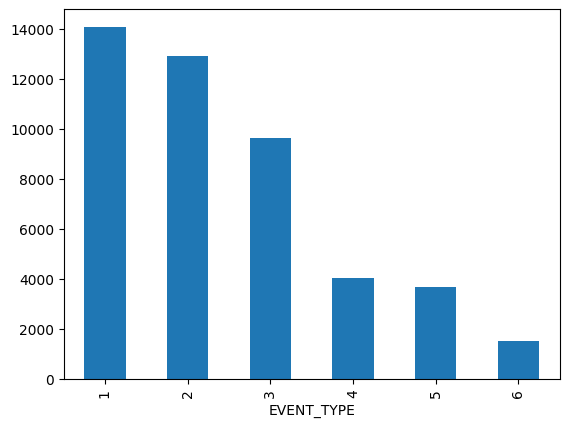

In [35]:
data_train.groupby(['EVENT_TYPE']).size().plot.bar()

In [36]:
data_valid['EVENT_TYPE'].value_counts()


1    3004
2    2798
3    2023
4     890
5     764
6     351
Name: EVENT_TYPE, dtype: int64

<Axes: xlabel='EVENT_TYPE'>

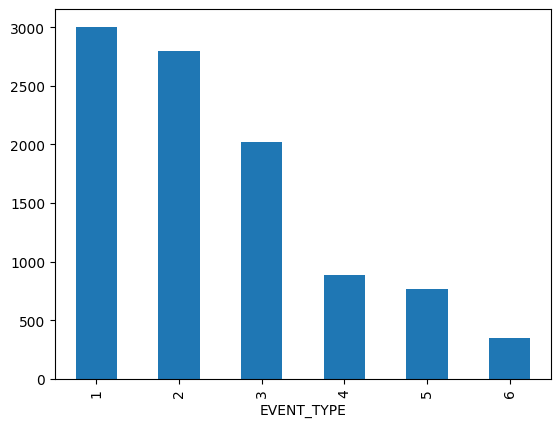

In [37]:
data_valid.groupby(['EVENT_TYPE']).size().plot.bar()

In [38]:
data_test['EVENT_TYPE'].value_counts()

1    3067
2    2722
3    2060
4     827
5     809
6     346
Name: EVENT_TYPE, dtype: int64

<Axes: xlabel='EVENT_TYPE'>

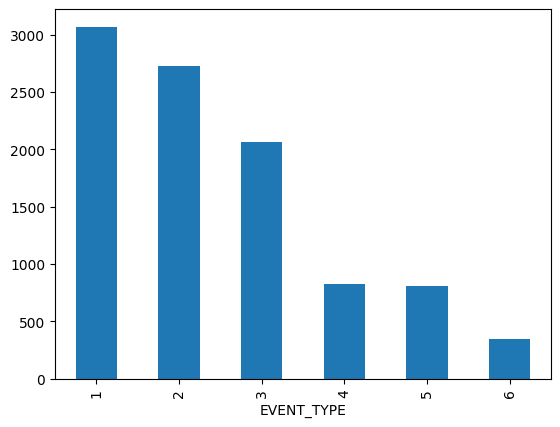

In [39]:
data_test.groupby(['EVENT_TYPE']).size().plot.bar()

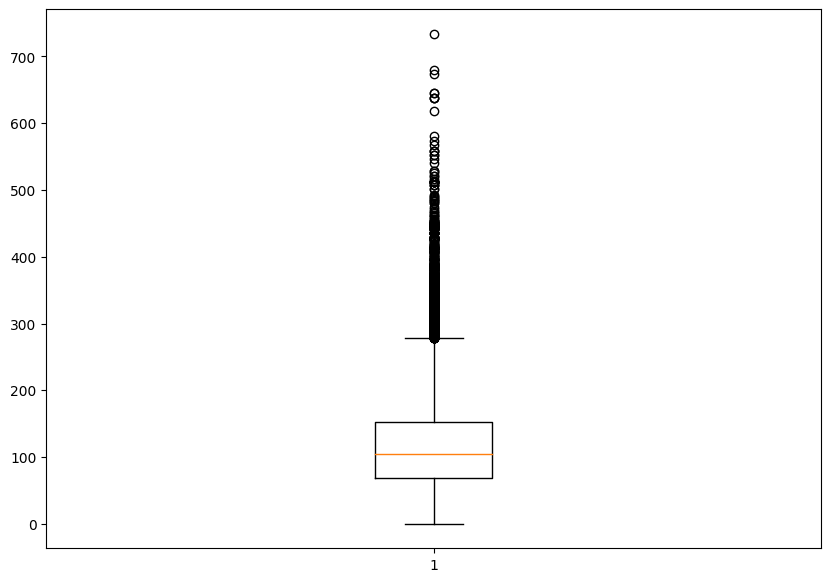

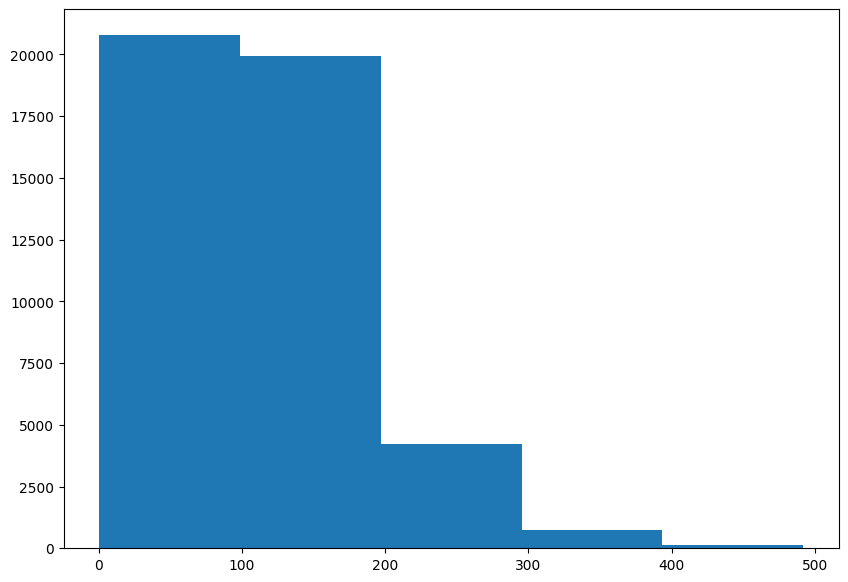

In [40]:
#Analyzing length of sentences in training data to decide on MAX_LENGTH variable, which is required for BERT and RoBERTa

sent_len = []
for sent in data_train['NOTES']:
  sent_len.append(len(sent))

fig = plt.figure(figsize =(10, 7))
plt.boxplot(sent_len)
plt.show()

sent_len = [i for i in sent_len if i<=500] #Excluding the outliers
fig2 = plt.figure(figsize =(10, 7))
plt.hist(sent_len, 5)
plt.show()

From the above histogram, we can see that, majority of the sentences are in the range of 200. 

In [41]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU device not found')

GPU device not found


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [42]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [43]:
torch.version.cuda # 10.2
torch.cuda.is_available()

False

# **Installing the Hugging Face Library**

In [44]:

bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
                                                                num_labels = 6, # The number of output labels  
                                                                output_attentions = False, # Whether the model returns attentions weights.
                                                                output_hidden_states = False # Whether the model returns all hidden-states.
                                                          )
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# Tell pytorch to run this model on the GPU.
# bert_model.cuda()

c:\Users\Hammad\Documents\Python_Envs\bert_trans_env\lib\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Hammad\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification:

In [45]:
# Loading RoBERTa base model
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", #RoBERTa base model
                                                                    num_labels = 6,  #number of output labels - 0,1 (//binary// multy classification)
                                                                    output_attentions = False,  #model doesnt return attention weights
                                                                    output_hidden_states = False #model doesnt return hidden states
                                                                )
#RoBERTa tokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=True)

# Tell pytorch to run this model on the GPU.
# roberta_model.cuda()

print(' Base models loaded') 

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

 Base models loaded


Demonstrating how  RoBERTa tokenizers work on a sample sentence

In [46]:
# Print the original sentence.
print(' Original: ', data_train["NOTES"][0])

# Print the tweet split into tokens.
print('Tokenized BERT: ', bert_tokenizer.tokenize(data_train["NOTES"][0]))

# Print the tweet mapped to token ids.
print('Token IDs BERT: ', bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(data_train["NOTES"][0])))

# Split the sentence into tokens -RoBERTa
print('Tokenized RoBERT: ', roberta_tokenizer.tokenize(data_train["NOTES"][0]))

# Mapping tokens to token IDs - RoBERTa
print('Token IDs RoBERTa: ', roberta_tokenizer.convert_tokens_to_ids(roberta_tokenizer.tokenize(data_train["NOTES"][0])))

 Original:   january beheading  citizens douaouda tipaza
Tokenized BERT:  ['january', 'be', '##head', '##ing', 'citizens', 'do', '##ua', '##oud', '##a', 'tip', '##az', '##a']
Token IDs BERT:  [2254, 2022, 4974, 2075, 4480, 2079, 6692, 19224, 2050, 5955, 10936, 2050]
Tokenized RoBERT:  ['Ġjan', 'uary', 'Ġbe', 'heading', 'Ġ', 'Ġcitizens', 'Ġdou', 'a', 'oud', 'a', 'Ġtip', 'aza']
Token IDs RoBERTa:  [10408, 16705, 28, 29086, 1437, 2286, 25605, 102, 6998, 102, 4767, 11868]


BERT Tokenizer

Here, the BERT tokenizer splits the string into multiple substrings. If the substrings are in its vocabulary, they will stay as is: this is the case for Cities, Taking and List. However, if a resulting string is not in its vocabulary, it will be split again until every string is represented by its vocabulary. For example, Transplanted is split multiple times until every token is represented in the BERT vocabulary: it is split into three tokens. The BERT tokenizer is lacking when it comes to complex characters spread over multiple bytes, as can be seen with emojis. In the sequence used, an emoji of a Cityscape was added. As the BERT tokenizer cannot interpret this emoji on a byte-level, it replaces it by the unknown token [UNK].

RoBERTa Tokenizer

On the other hand, the RoBERTa tokenizer has a slightly different approach. Here too, the string is split into multiple substrings, which are themselves split into multiple substrings until every substring can be represented by the vocabulary. However, the RoBERTa tokenizer has a byte-level approach. This tokenizer can represent every sequence as a combination of bytes, which makes it shine in the case of complex characters spread over multiple bytes, as with the Cityscape emoji. Instead of using the unknown token, this tokenizer can correctly encode the Cityscape emoji as the combination of multiple bytes. This tokenizer therefore does not require an unknown token, as it can handle every byte separately.

The transformers library provides a helpful encode function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a maximum sentence length for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [47]:
max_len_bert = 0
max_len_roberta = 0

# For every sentence...
for sent in data_train["NOTES"]:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids_bert = bert_tokenizer.encode(sent, add_special_tokens=True)
    input_ids_roberta = roberta_tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len_bert = max(max_len_bert, len(input_ids_bert))
    max_len_roberta = max(max_len_roberta, len(input_ids_roberta))

    
print('Max sentence length BERT: ', max_len_bert)
print('Max sentence length RoBERTa: ', max_len_roberta)

Max sentence length BERT:  132
Max sentence length RoBERTa:  133


The special tokens have specific meanings: [SEP] is a separator token and [CLS] is a token that will be used to predict whether or not Part B is a sentence that directly follows Part A. To train the language model, 15% of the words in Part A and Part B are masked with the [MASK] token.

In [50]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
bert_input_ids = []
bert_attention_masks = []
roberta_input_ids = []
roberta_attention_masks = []
sentence_ids = []
counter = 0

# For every sentence...
for sent in data_train["NOTES"]:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start. (classification level sentence - bert)
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    bert_encoded_dict = bert_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
    
    
    roberta_encoded_dict = roberta_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
    # Add the encoded sentence to the list.    
    bert_input_ids.append(bert_encoded_dict['input_ids'])
    roberta_input_ids.append(roberta_encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    bert_attention_masks.append(bert_encoded_dict['attention_mask'])
    roberta_attention_masks.append(roberta_encoded_dict['attention_mask'])
    
    # collecting sentence_ids
    sentence_ids.append(counter)
    counter  = counter + 1
    
    
    
# Convert the lists into tensors.
bert_input_ids = torch.cat(bert_input_ids, dim=0)
bert_attention_masks = torch.cat(bert_attention_masks, dim=0)

roberta_input_ids = torch.cat(roberta_input_ids, dim=0)
roberta_attention_masks = torch.cat(roberta_attention_masks, dim=0)


# Print sentence 0, now as a list of IDs.
print('Original: ', data_train["NOTES"][1])
print('Token IDs BERT:', bert_input_ids[1])
print('Token IDs RoBERTa:', roberta_input_ids[1])

c:\Users\Hammad\Documents\Python_Envs\bert_trans_env\lib\site-packages\transformers\tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  two citizens beheaded hassasna
Token IDs BERT: tensor([  101,  2730,  2463, 21179,  2057,  6820,  9587, 24141, 16366,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Token

In [ ]:
labels = torch.tensor(data_train['EVENT_TYPE'])
sentence_ids = torch.tensor(sentence_ids)

In [42]:
#assigning sentences and labels to separate variables
sentences = data_train["NOTES"].values
labels = data_train["EVENT_TYPE"].values

In [43]:
data_train['NOTES'][10]

'clashes military militants region douade tipaza'

In [44]:
max_len_bert = 0
max_len_roberta = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    
    input_ids_roberta = roberta_tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
   
    max_len_roberta = max(max_len_roberta, len(input_ids_roberta))

    

print('Max sentence length RoBERTa: ', max_len_roberta)

Max sentence length RoBERTa:  133


In [45]:
# Below function performs tokenization process as required by bert and roberta models, for a given dataset
def bert_robert_tokenization(dataset):
  sentences  = dataset["NOTES"].values
  labels  = dataset["EVENT_TYPE"].values
  max_length = 200

  # Tokenize all of the sentences and map the tokens to thier word IDs.
 
  roberta_input_ids = []
  roberta_attention_masks = []

  sentence_ids = []
  counter = 0

  # For every sentence...
  for sent in sentences:
      #encode_plus function will encode the sentences as required by model, 
      #including tokenization process and mapping token ids
      
      
      roberta_encoded_dict = roberta_tokenizer.encode_plus(
                          str(sent),        #sentence
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]' tokens 
                          max_length = 130,        #Since we have seen from our analysis that majority of sentences have length less than 300.   
                          pad_to_max_length = True,     # Pad sentences to 256 length  if the length of sentence is less than max_length
                          return_attention_mask = True,   # Create attention mask
                          truncation = True,   # truncate sentences to 256 length  if the length of sentence is greater than max_length
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
    
      # Add the encoded sentence to the list.    
    
      roberta_input_ids.append(roberta_encoded_dict['input_ids'])
      
      
      # Add attention mask to the list 
      
      roberta_attention_masks.append(roberta_encoded_dict['attention_mask'])
      
      
      # collecting sentence_ids
      sentence_ids.append(counter)
      counter  = counter + 1
      
      
      
  # Convert the lists into tensors.
  

  roberta_input_ids = torch.cat(roberta_input_ids, dim=0)
  roberta_attention_masks = torch.cat(roberta_attention_masks, dim=0)


  labels = torch.tensor(labels)
  sentence_ids = torch.tensor(sentence_ids)

  return { "Roberta":[roberta_input_ids, roberta_attention_masks, labels]}

In [46]:
# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[1])
print('Token IDs BERT:', bert_input_ids[1])
print('Token IDs RoBERTa:', roberta_input_ids[1])

Original:   killed km pont weru mogoloko


NameError: name 'bert_input_ids' is not defined

In [47]:
from torch.utils.data import TensorDataset, random_split
# function to seed the script globally
torch.manual_seed(0)

#tokenizing train set
token_dict_train = bert_robert_tokenization(data_train)
roberta_input_ids, roberta_attention_masks, labels = token_dict_train["Roberta"]

#tokenizing validation set
token_dict_valid = bert_robert_tokenization(data_valid)
roberta_input_ids_valid, roberta_attention_masks_valid, labels_valid = token_dict_valid["Roberta"]

#tokenizing test set
token_dict_test = bert_robert_tokenization(data_test)
roberta_input_ids_test, roberta_attention_masks_test, labels_test = token_dict_test["Roberta"]

/home/hammad/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [48]:
# Combine the training inputs into a TensorDataset.
roberta_train_dataset = TensorDataset(roberta_input_ids, roberta_attention_masks, labels)

# Combine the validation inputs into a TensorDataset.
roberta_val_dataset = TensorDataset(roberta_input_ids_valid, roberta_attention_masks_valid, labels_valid)

In [49]:
# Combine the test inputs into a TensorDataset.
roberta_test_dataset = TensorDataset(roberta_input_ids_test, roberta_attention_masks_test, labels_test)

 The DataLoader needs to know our batch size for training, so we specify it 
 here. For fine-tuning BERT on a specific task, the authors recommend a 
 **batch size of 16 or 32**.

In [50]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoaders for our training - Loads the data randomly in batches of size 32

roberta_train_dataloader = DataLoader(
            roberta_train_dataset,  # The training samples.
            sampler = RandomSampler(roberta_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# Create the DataLoaders for our validation - Loads the data in batches of size 32

roberta_validation_dataloader = DataLoader(
            roberta_val_dataset, # The validation samples.
            sampler = SequentialSampler(roberta_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

For the purposes of fine-tuning, the authors recommend choosing from the following values :

Batch size: 16, 32 Learning rate (Adam): 5e-5, 3e-5, 2e-5 Number of epochs: 2, 3, 4 We chose:

Batch size: 32 (set when creating our DataLoaders) Learning rate: 2e-5 Epochs: 4 (we'll see that this is probably too many...) The epsilon parameter eps = 1e-8 is "a very small number to prevent any division by zero in the implementation"

In [51]:
# optimizers - AdamW
# here, i have used default learning rate and epsilon values for RoBERTa


roberta_optimizer = AdamW(roberta_model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8. 
                )

/home/hammad/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [52]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]
#total_steps = len(bert_train_dataloader) * epochs
total_steps = len( roberta_train_dataloader) * epochs
# Create the learning rate scheduler.
roberta_scheduler = get_linear_schedule_with_warmup(roberta_optimizer, 
                                            num_warmup_steps = 0,# Default value in run_glue.py
                                            num_training_steps = total_steps)



In [53]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [54]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [55]:
import torch

# tell pytorch to use the gpu if available
if torch.cuda.is_available():    
      
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


**BERT - Training and Validation**

In [ ]:
'''
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# Set the seed value all over the place to make this reproducible.
seed_val = 112
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
loss_values = []
for epoch_i in range(0, epochs):
    #Training 
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    bert_model.train()
    # For each batch of training data...
    for step, batch in enumerate(bert_train_dataloader):
      #Report progress after every 40 epochs
        if step % 40 == 0 and not step == 0: 
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # print current training batch and elapsed time
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(bert_train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        bert_model.zero_grad()        
        
        outputs = bert_model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # model returns a tuple, extract loss value from that tuple
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)
        bert_optimizer.step()
        
        bert_scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(bert_train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    #Validation Part

    
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode    
    bert_model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in bert_validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():        
           outputs = bert_model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
print("")
print("Training complete!")

'''

In [ ]:
'''

#Plotting the training loss over epochs
import plotly.express as px
f = pd.DataFrame(loss_values)
f.columns=['Loss']
fig = px.line(f, x=f.index, y=f.Loss)
fig.update_layout(title='Training loss of the Model',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')
fig.show()

'''


# **Testing Part**

In [ ]:
'''
bert_prediction_sampler = SequentialSampler(bert_test_dataset)
bert_prediction_dataloader = DataLoader(bert_test_dataset, sampler=bert_prediction_sampler, batch_size=batch_size)
'''

In [ ]:
'''
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(bert_input_ids_test)))

# Put model in evaluation mode
bert_model.eval()

# Tracking variables 
predictions , true_labels = [], []

'''

In [ ]:
'''
# Predict 
for batch in bert_prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
 
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = bert_model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('    DONE.')
'''


DONE.
Classsification Report and Confusion Matrix for Test set


In [ ]:
'''
predictions_labels = [item for subitem in predictions for item in subitem]

predictions_labels = np.argmax(predictions_labels, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

from sklearn.metrics import classification_report, confusion_matrix

print (classification_report(predictions_labels, flat_true_labels))
print(confusion_matrix(flat_true_labels, predictions_labels))

'''

# **ROBERTA - Training and Validation**

In [56]:
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# Set the seed value all over the place to make this reproducible.
seed_val = 200
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
loss_values = []
# For each epoch...
for epoch_i in range(0, epochs):
    
    # Training

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    roberta_model.train()
    # For each batch of training data...
    for step, batch in enumerate(roberta_train_dataloader):
        # Report progress after every 40 epochs
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            #Printing current batch and elapsed time
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(roberta_train_dataloader), elapsed))
        
# Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        roberta_model.zero_grad()  # Always clear any previously calculated
                                   # gradients before performing a backward pass.
                                   # PyTorch doesn't do this automatically because 
                                   # accumulating the gradients is "convenient 
                                   #while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)      
        


        # Perform a forward pass (evaluate the roberta_model on this training batch).
        # The documentation for this `roberta_model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/roberta_model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # are given and what flags are set. For our usage here, it returns
        # the loss (because we provided labels) and the "logits"--the roberta_model
        # outputs prior to activation.
        outputs = roberta_model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # Model returns tuple, extract loss value from that tuple
        loss = outputs[0]
        
        total_loss += loss.item()
        loss.backward() # Perform a backward pass to calculate the gradients.
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(roberta_model.parameters(), 1.0)
        roberta_optimizer.step()
        
        roberta_scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(roberta_train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # Validation
    
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode    
    roberta_model.eval()   # Put the roberta_model in evaluation
                           # mode--the dropout layers behave differently
    
    
    # during evaluation. # Tracking variables 
     
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in roberta_validation_dataloader:
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():        
           
            outputs = roberta_model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...


IndexError: Target 6 is out of bounds.

Testing Part

In [ ]:
                                          
roberta_prediction_sampler = SequentialSampler(roberta_test_dataset)
roberta_prediction_dataloader = DataLoader(roberta_test_dataset, sampler=roberta_prediction_sampler, batch_size=batch_size)                                           

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(bert_input_ids_test)))

# Put model in evaluation mode
roberta_model.eval()

# Tracking variables 
predictions , true_labels = [], []

In [ ]:
# Predict 
for batch in roberta_prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      
      outputs = roberta_model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('    DONE.')

DONE.

Classification report and Confusion Matrix for test set

In [ ]:
predictions_labels = [item for subitem in predictions for item in subitem]

predictions_labels = np.argmax(predictions_labels, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

from sklearn.metrics import classification_report, confusion_matrix

print (classification_report(predictions_labels, flat_true_labels))
print(confusion_matrix(flat_true_labels, predictions_labels))

References: https://www.kaggle.com/jaskaransingh/fake-news-classification-bert-roberta